In [117]:
from load_mnist import *
import numpy as np
import pandas as pd
# import seaborn as sn
%load_ext autoreload
%autoreload 2

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import datetime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def plot_images(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Load traditional MNIST dataset
This dataset is taken from http://yann.lecun.com/exdb/mnist/

In [3]:
images_tr, labels_tr = load_mnist('MNIST/')
images_tst, labels_tst = load_mnist('MNIST/', 't10k')

X_tr, y_tr = images_tr, labels_tr
X_tst, y_tst = images_tst, labels_tst

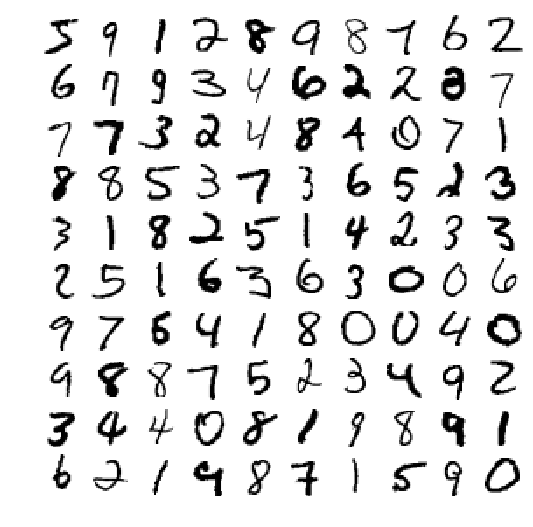

In [4]:
# show some images
plt.figure(figsize=(9,9))
example_images = np.r_[X_tr[:12000:600], X_tr[13000:30600:600], X_tr[30600:60000:590]]
plot_images(example_images, images_per_row=10)
# save_fig("more_images_plot")
plt.show()

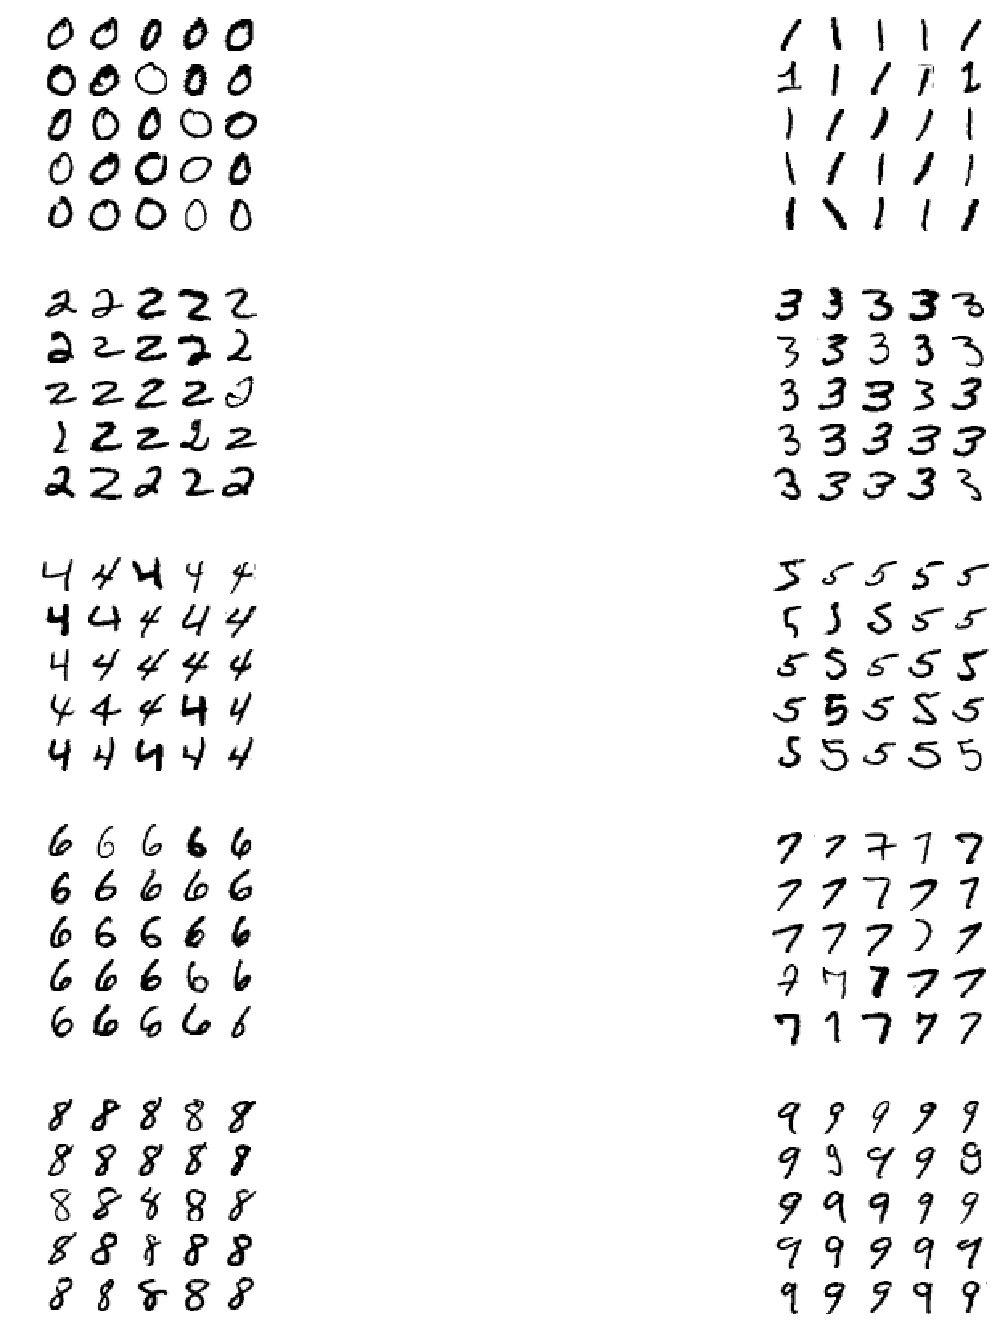

In [5]:
# plot images for each label
X_0 = X_tr[(y_tr == 0)]
X_1 = X_tr[(y_tr == 1)]
X_2 = X_tr[(y_tr == 2)]
X_3 = X_tr[(y_tr == 3)]
X_4 = X_tr[(y_tr == 4)]
X_5 = X_tr[(y_tr == 5)]
X_6 = X_tr[(y_tr == 6)]
X_7 = X_tr[(y_tr == 7)]
X_8 = X_tr[(y_tr == 8)]
X_9 = X_tr[(y_tr == 9)]

plt.figure(figsize=(24,24))
plt.subplot(521); plot_images(X_0[:25], images_per_row=5)
plt.subplot(522); plot_images(X_1[:25], images_per_row=5)
plt.subplot(523); plot_images(X_2[:25], images_per_row=5)
plt.subplot(524); plot_images(X_3[:25], images_per_row=5)
plt.subplot(525); plot_images(X_4[:25], images_per_row=5)
plt.subplot(526); plot_images(X_5[:25], images_per_row=5)
plt.subplot(527); plot_images(X_6[:25], images_per_row=5)
plt.subplot(528); plot_images(X_7[:25], images_per_row=5)
plt.subplot(529); plot_images(X_8[:25], images_per_row=5)
plt.subplot(5,2,10); plot_images(X_9[:25], images_per_row=5)
# save_fig("images_for_each_label")
plt.show()

## Binary Classifier

Choose 5 and 6

In [6]:
train_filter = np.where((y_tr == 5 ) | (y_tr == 6))
test_filter = np.where((y_tst == 5) | (y_tst == 6))

X_tr_b, y_tr_b = X_tr[train_filter], y_tr[train_filter]
X_tst_b, y_tst_b = X_tst[test_filter], y_tst[test_filter]

y_tr_binary = (y_tr_b == 5).astype(np.int)
y_tst_binary = (y_tst_b == 5).astype(np.int)

y_tr_binary_expand = np.expand_dims(y_tr_binary, axis=1)
y_tst_binary_expand = np.expand_dims(y_tst_binary, axis=1)

In [7]:
def sigmoid(t):
    return np.exp(t) / (1 + np.exp(t))

In [8]:
def calculate_loss(y, tx, w):
    p = sigmoid(tx.dot(w))
    loss = np.sum(-y * np.log(p) - (1 - y) * np.log(1 - p)) / y.shape[0]
    return loss

In [9]:
def calculate_gradient(y, tx, w):
    p = sigmoid(tx.dot(w))
    gradient = np.dot(tx.T, (p - y)) / y.shape[0]
    return gradient

In [10]:
def learning_by_gradient_descent(y, tx, w, tau):
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    w -= tau * gradient
    return loss, w

In [11]:
def predict_probs(tx, w):
    return sigmoid(tx.dot(w))

In [12]:
def predict(tx, w, threshold=0.5):
    return predict_probs(tx, w) >= threshold

In [103]:
def logistic_regression_gradient_descent_demo(y, x, max_iter, tau):
    # init parameters
    max_iter = max_iter
    threshold = 1e-8
    tau = tau #change to see the diff
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # Start GD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_gradient_descent(y, tx, w, tau)
        prediction = predict(tx, w, threshold=0.5).astype(np.int)
#         print(prediction)
        accuracy = (prediction == y).mean()
        tprediction = predict(np.c_[np.ones((y_tst_b.shape[0], 1)), X_tst_b], w, threshold=0.5).astype(np.int)
        taccuracy = (tprediction == y_tst_binary_expand).mean()
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # visualization
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("Binary GD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(y, tx, w)))
    
    # return for confusion matrix
    y_pred = prediction.flatten()
    y_act = y.flatten()
    return y_pred, y_act
    

Current iteration=0, loss=0.6931471805599453, training accuracy=0.7917805802980863, test accuracy=0.8043243243243243
Current iteration=100, loss=0.07303169157738475, training accuracy=0.9759238028044801, test accuracy=0.98
Current iteration=200, loss=0.06543140206158721, training accuracy=0.9776876267748479, test accuracy=0.98
Current iteration=300, loss=0.061111596470885224, training accuracy=0.9785695387600317, test accuracy=0.981081081081081
Current iteration=400, loss=0.058113729390850556, training accuracy=0.979539641943734, test accuracy=0.9816216216216216
Binary GD: execution time=7.640 seconds


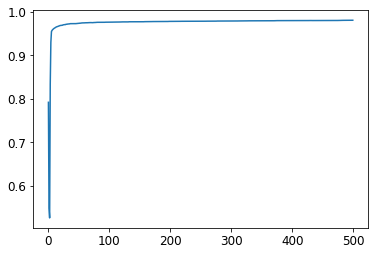

In [104]:
y_pred, y_act = logistic_regression_gradient_descent_demo(y_tr_binary_expand, X_tr_b, 500, 1e-5)

In [105]:
print(y_pred)
print(y_act)

[1 1 0 ... 1 1 0]
[1 1 0 ... 1 1 0]


In [124]:
# Visualize the Confusion Matrix
# np.set_printoptions(suppress=True) # disable scientific numbers
y_act = pd.Series(y_act, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
conf_mat = pd.crosstab(y_act, y_pred)
# Normalized confusion matrix
conf_mat_norm = conf_mat / conf_mat.sum(axis=1)
# print(df_confusion)
# sn.heatmap(conf_mat, annot=True)

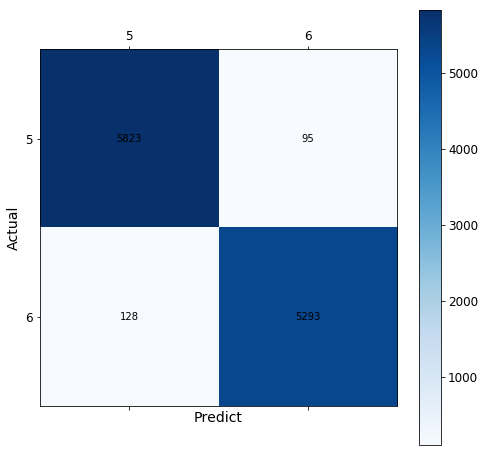

In [136]:
labels = ['5', '6']
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
# plt.title('Binary Confusion Matrix',fontsize=16)
plt.xlabel('Predict')
plt.ylabel('Actual')

for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:0}'.format(z), ha='center', va='center') # for default in integer
#     ax.text(j, i, '{:0.2%}'.format(z), ha='center', va='center') # for normalized in percentage
    
plt.show()

In [143]:
# Precision and Recall rate
TP = 5823
FP = 128
FN = 95
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print("Precision Rate: {pr:.3f}\nRecall Rate:    {rr:.3f}".format(pr=precision,rr=recall))

Precision Rate: 0.978
Recall Rate:    0.984


## Newton's method

In [191]:
def calculate_hessian(y, tx, w):
    p = sigmoid(tx.dot(w)) 
    hessian = np.dot(tx.T, np.diag(p * (1 - p))*tx) / y.shape[0]
    return hessian

In [192]:
def logistic_regression(y, tx, w):
    loss = calculate_loss(y, tx, w)
    gradient = calculate_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w)
    return loss, gradient, hessian

In [193]:
def learning_by_newton_method(y, tx, w):
    loss, gradient, hessian = logistic_regression(y, tx, w)
    w -= np.linalg.solve(hessian, gradient)
    return loss, w

In [194]:
def logistic_regression_newton_method_demo(y, x):
    # init parameters
    max_iter = 100
    threshold = 1e-8
    tau = 0.1
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 1))

    # Start Newton's
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w = learning_by_newton_method(y, tx, w)
        # log info
        prediction = predict(tx, w, threshold=0.5).astype(np.int)
        accuracy = (prediction == y).mean()
        tprediction = predict(np.c_[np.ones((y_tst_b.shape[0], 1)), X_tst_b], w, threshold=0.5).astype(np.int)
        taccuracy = (tprediction == y_tst_binary_expand).mean()
        if iter % 1 == 0:
            print("Current iteration={i}, the loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        losses.append(loss)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break

    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("Newton's: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)

In [195]:
logistic_regression_newton_method_demo(y_tr_binary_expand, X_tr_b)

LinAlgError: Singular matrix

## Softmax

In [74]:
def onehotencoding(y):
    return (np.arange(np.max(y) + 1) == y[:, None]).astype(np.int)

In [75]:
def softmax(z):
    z -= np.max(z)
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [76]:
def calculate_loss(y, tx, w):
    softm = softmax(tx.dot(w))
    loss = -(np.sum(y * np.log(softm)) / y.shape[0])
    prediction = np.argmax(softm, axis=1)
    return softm, loss, prediction

In [77]:
def calculate_gradient(y, tx, w):
    softm = softmax(tx.dot(w))
    return - np.dot(tx.T, (y - softm)) / y.shape[0]

In [78]:
def learning_by_gradient_descent(y, tx, w, tau):
    y_enc = onehotencoding(y)
    softm, loss, prediction = calculate_loss(y_enc, tx, w)
    loss += (tau/2) * np.sum(w*w)
    gradient = calculate_gradient(y_enc, tx, w)
    gradient += tau*w
    w -= tau * gradient
    accuracy = np.sum(prediction == y)/ y.shape[0]
    return loss, w, accuracy

In [79]:
def getAccuracy(x, y, w):
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    softm = softmax(tx.dot(w))
    prediction = np.argmax(softm, axis=1)
    accuracy = np.sum(prediction == y)/ y.shape[0]
    return accuracy

In [80]:
def logistic_regression_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 1000
    threshold = 1e-8
    tau = 1e-5 #change to see the diff
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))
    
    # Start GD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w, accuracy = learning_by_gradient_descent(y, tx, w, tau)
        taccuracy = getAccuracy(X_tst, y_tst, w)
        # log info
        if iter % 10 == 0:
            print("Current iteration={i}, loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        losses.append(loss)
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(onehotencoding(y), tx, w)))

Current iteration=0, loss=2.3025850929940437, training accuracy=0.09871666666666666, test accuracy=0.6804
Current iteration=10, loss=0.7526967217235341, training accuracy=0.8159, test accuracy=0.8282
Current iteration=20, loss=0.5523132726978303, training accuracy=0.8644333333333334, test accuracy=0.8748
Current iteration=30, loss=0.4906816204928329, training accuracy=0.8752166666666666, test accuracy=0.8843
Current iteration=40, loss=0.4561556231936041, training accuracy=0.8816333333333334, test accuracy=0.8902
Current iteration=50, loss=0.4330377646970308, training accuracy=0.88605, test accuracy=0.8936
Current iteration=60, loss=0.416193388801239, training accuracy=0.8888, test accuracy=0.8973
Current iteration=70, loss=0.4032211909917972, training accuracy=0.8921333333333333, test accuracy=0.8988
Current iteration=80, loss=0.3928327144441604, training accuracy=0.8943, test accuracy=0.901
Current iteration=90, loss=0.3842681591511476, training accuracy=0.8958166666666667, test accur

Current iteration=800, loss=0.29035030065598105, training accuracy=0.9191333333333334, test accuracy=0.92
Current iteration=810, loss=0.290038428674174, training accuracy=0.9191666666666667, test accuracy=0.92
Current iteration=820, loss=0.28973180387305103, training accuracy=0.9192166666666667, test accuracy=0.9199
Current iteration=830, loss=0.28943026918961834, training accuracy=0.9193333333333333, test accuracy=0.9201
Current iteration=840, loss=0.2891336741958624, training accuracy=0.9193666666666667, test accuracy=0.9202
Current iteration=850, loss=0.28884187474247286, training accuracy=0.9195, test accuracy=0.9203
Current iteration=860, loss=0.2885547326255451, training accuracy=0.9196166666666666, test accuracy=0.9205
Current iteration=870, loss=0.28827211527453633, training accuracy=0.9197833333333333, test accuracy=0.9202
Current iteration=880, loss=0.28799389545990567, training accuracy=0.9197833333333333, test accuracy=0.9202
Current iteration=890, loss=0.28771995101899045,

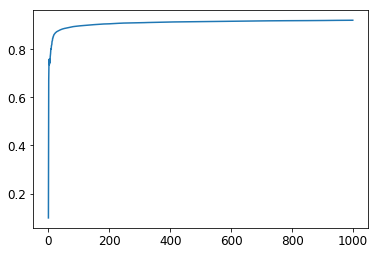

In [81]:
logistic_regression_gradient_descent_demo(y_tr, X_tr)

# Load fashion MNIST dataset
This dataset is taken from https://github.com/zalandoresearch/fashion-mnist

In [83]:
fashion_images_tr, fashion_labels_tr = load_mnist('FashionMNIST/')
fashion_images_tst, fashion_labels_tst = load_mnist('FashionMNIST/', 't10k')

X_tr, y_tr = fashion_images_tr, fashion_labels_tr
X_tst, y_tst = fashion_images_tst, fashion_labels_tst


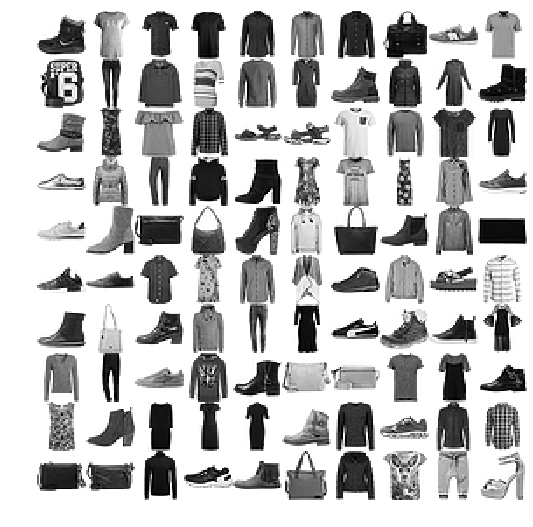

In [7]:
# show some images
plt.figure(figsize=(9,9))
example_images = np.r_[X_tr[:12000:600], X_tr[13000:30600:600], X_tr[30600:60000:590]]
plot_images(example_images, images_per_row=10)
# save_fig("more_images_plot")
plt.show()

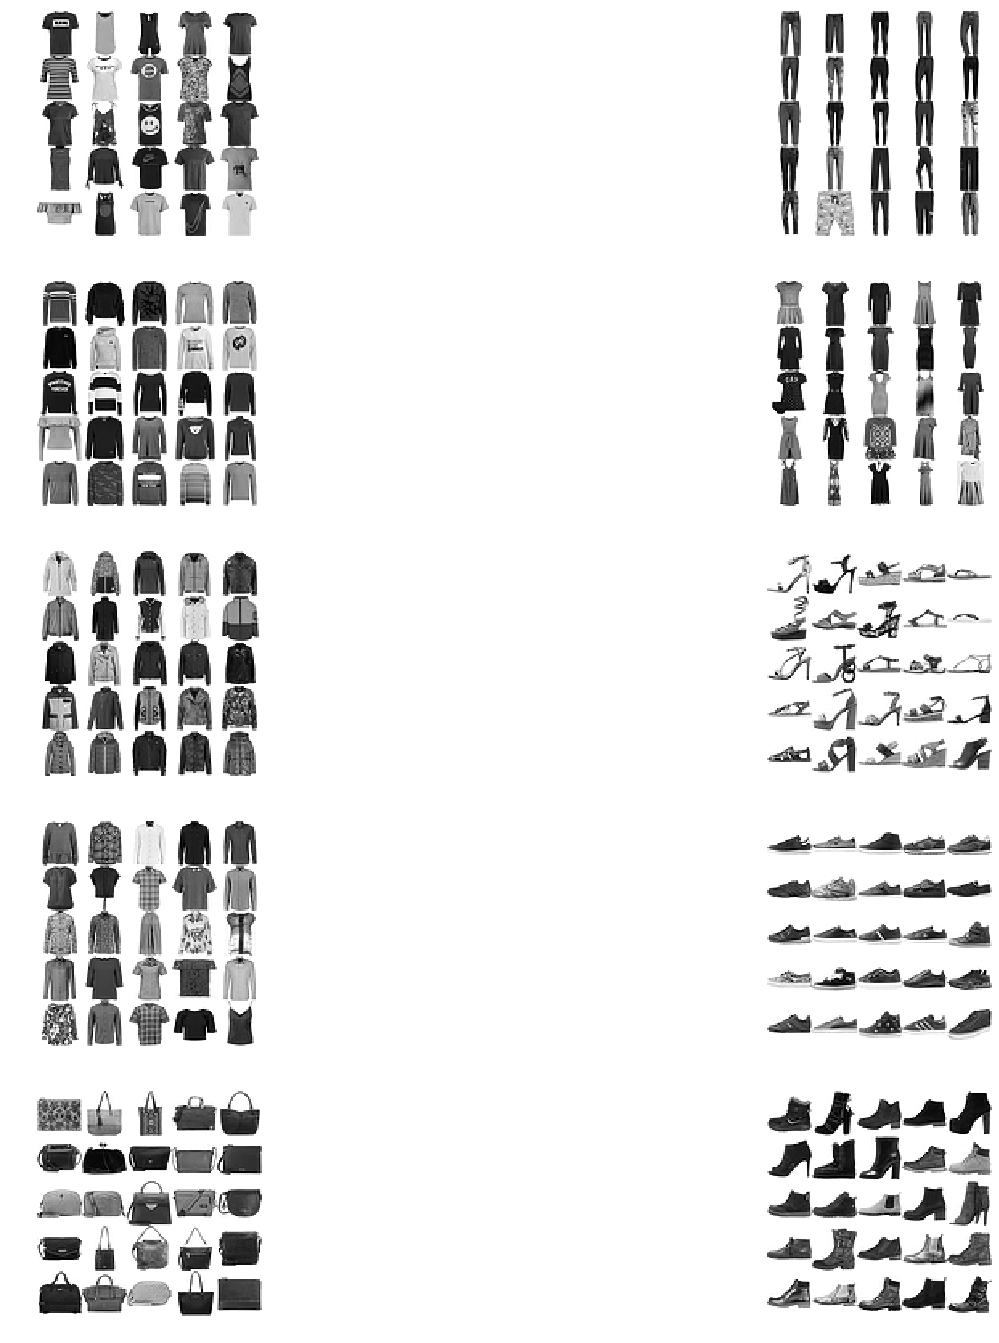

(6000, 784)


In [141]:
# plot images for each label
X_0 = X_tr[(y_tr == 0)]
X_1 = X_tr[(y_tr == 1)]
X_2 = X_tr[(y_tr == 2)]
X_3 = X_tr[(y_tr == 3)]
X_4 = X_tr[(y_tr == 4)]
X_5 = X_tr[(y_tr == 5)]
X_6 = X_tr[(y_tr == 6)]
X_7 = X_tr[(y_tr == 7)]
X_8 = X_tr[(y_tr == 8)]
X_9 = X_tr[(y_tr == 9)]

plt.figure(figsize=(24,24))
plt.subplot(521); plot_images(X_0[:25], images_per_row=5)
plt.subplot(522); plot_images(X_1[:25], images_per_row=5)
plt.subplot(523); plot_images(X_2[:25], images_per_row=5)
plt.subplot(524); plot_images(X_3[:25], images_per_row=5)
plt.subplot(525); plot_images(X_4[:25], images_per_row=5)
plt.subplot(526); plot_images(X_5[:25], images_per_row=5)
plt.subplot(527); plot_images(X_6[:25], images_per_row=5)
plt.subplot(528); plot_images(X_7[:25], images_per_row=5)
plt.subplot(529); plot_images(X_8[:25], images_per_row=5)
plt.subplot(5,2,10); plot_images(X_9[:25], images_per_row=5)
# save_fig("images_for_each_label")
plt.show()

print(X_0.shape)
print(X_1.shape)

## Softmax Regression

Compute your cost by negative log likelihood.

In [84]:
def onehotencoding(y):
    return (np.arange(np.max(y) + 1) == y[:, None]).astype(float)

In [85]:
def softmax(z):
    z -= np.max(z)
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [86]:
def calculate_loss(y, tx, w):
    softm = softmax(tx.dot(w))
    loss = - np.sum(y * np.log(softm)) / y.shape[0]
    prediction = np.argmax(softm, axis=1)
    return softm, loss, prediction

In [87]:
def calculate_gradient(y, tx, w):
    softm = softmax(tx.dot(w))
    return - np.dot(tx.T, (y - softm)) / y.shape[0]

In [92]:
def learning_by_gradient_descent(y, tx, w, tau, alpha):
    y_enc = onehotencoding(y)
    softm, loss, prediction = calculate_loss(y_enc, tx, w)
    loss += (alpha/2) * np.sum(w*w)
    gradient = calculate_gradient(y_enc, tx, w)
    gradient += alpha*w
    w -= tau * gradient
    accuracy = np.sum(prediction == y)/ y.shape[0]
    return loss, w, accuracy

In [93]:
def getAccuracy(x, y, w):
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    softm = softmax(tx.dot(w))
    prediction = np.argmax(softm, axis=1)
    accuracy = np.sum(prediction == y)/ y.shape[0]
    return accuracy

In [94]:
def logistic_regression_penalized_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 1000
    threshold = 1e-8
    tau = 1e-6 #change to see the diff
    alpha = 1e-7
    losses = []
    accuracies = []

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # Start GD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w, accuracy = learning_by_gradient_descent(y, tx, w, tau, alpha)
        taccuracy = getAccuracy(X_tst, y_tst, w)
        # log info
        if iter % 10 == 0:
            print("Current iteration={i}, loss={l}, training accuracy={a}, test accuracy={ta}"
                  .format(i=iter, l=loss, a=accuracy, ta=taccuracy))
        # converge criterion
        losses.append(loss)
        accuracies.append(accuracy)
        if len(losses) > 1 and np.abs(losses[-1] - losses[-2]) < threshold:
            break
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    #plt.plot(losses)
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(onehotencoding(y), tx, w)))

Current iteration=0, loss=2.302585092994043, training accuracy=0.1, test accuracy=0.3043
Current iteration=10, loss=1.4883527832425107, training accuracy=0.6635166666666666, test accuracy=0.6546
Current iteration=20, loss=1.2091873165061204, training accuracy=0.66965, test accuracy=0.6612
Current iteration=30, loss=1.0710990600701562, training accuracy=0.6813166666666667, test accuracy=0.6717
Current iteration=40, loss=0.9876013369710637, training accuracy=0.6929666666666666, test accuracy=0.6825
Current iteration=50, loss=0.9306010693311803, training accuracy=0.7055166666666667, test accuracy=0.694
Current iteration=60, loss=0.8885054361831577, training accuracy=0.7181833333333333, test accuracy=0.706
Current iteration=70, loss=0.8556950289993156, training accuracy=0.7288166666666667, test accuracy=0.7149
Current iteration=80, loss=0.829115134098082, training accuracy=0.7369666666666667, test accuracy=0.724
Current iteration=90, loss=0.806956316349584, training accuracy=0.74345, test 

Current iteration=800, loss=0.541075968712738, training accuracy=0.82255, test accuracy=0.8093
Current iteration=810, loss=0.5401409075416825, training accuracy=0.8227166666666667, test accuracy=0.8098
Current iteration=820, loss=0.5392220861629625, training accuracy=0.8229666666666666, test accuracy=0.8098
Current iteration=830, loss=0.5383190282868032, training accuracy=0.8233166666666667, test accuracy=0.8101
Current iteration=840, loss=0.5374312769981376, training accuracy=0.8237166666666667, test accuracy=0.8104
Current iteration=850, loss=0.5365583937565728, training accuracy=0.82395, test accuracy=0.8103
Current iteration=860, loss=0.5356999574588458, training accuracy=0.8242166666666667, test accuracy=0.8111
Current iteration=870, loss=0.534855563559179, training accuracy=0.8243, test accuracy=0.8113
Current iteration=880, loss=0.5340248232433455, training accuracy=0.8245833333333333, test accuracy=0.8116
Current iteration=890, loss=0.5332073626525788, training accuracy=0.82485

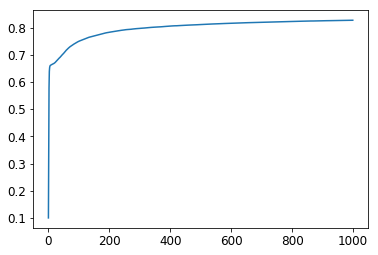

In [95]:
logistic_regression_penalized_gradient_descent_demo(y_tr, X_tr)

## Stochastic Gradient Descent

In [129]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [130]:
def stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha):
    """Stochastic gradient descent."""
    losses = []
    accuracies = []
    y_enc = onehotencoding(y)
    for n_iter in range(max_iter):
        for y_batch, tx_batch in batch_iter(y_enc, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            gradient = calculate_gradient(y_batch, tx_batch, w)
            gradient += alpha*w
            # calculate loss
            softm, loss, prediction = calculate_loss(y_enc, tx, w)
            loss += (alpha/2) * np.sum(w*w)
            # update w through the stochastic gradient update
            w -= tau * gradient
            accuracy = np.sum(prediction == y)/ y.shape[0]
            taccuracy = getAccuracy(X_tst, y_tst, w)
            losses.append(loss)
        print("SGD({bi}/{ti}): loss={l}, training accuracy={a}, test accuracy={ta}".format(
              bi=n_iter, ti=max_iter - 1, l=loss, a=accuracy, ta=taccuracy))
    return loss, w, accuracy

In [139]:
def logistic_regression_stochastic_gradient_descent_demo(y, x):
    # init parameters
    max_iter = 1000
    threshold = 1e-8
    tau = 1e-6 #change to see the diff
    alpha = 1e-7
    batch_size = 1

    # build tx
    tx = np.c_[np.ones((y.shape[0], 1)), x]
    w = np.zeros((tx.shape[1], 10))

    # Start SGD
    start_time = datetime.datetime.now()
    
    # start the logistic regression
    # get loss and update w.
    loss, w, accuracy = stochastic_gradient_descent(y, tx, w, batch_size, max_iter, tau, alpha)
    #taccuracy = getAccuracy(X_tst, y_tst, w)
    # log info
    # Print result
    end_time = datetime.datetime.now()
    exection_time = (end_time - start_time).total_seconds()
    print("SGD: execution time={t:.3f} seconds".format(t=exection_time))
    # visualization
    plt.plot(accuracies)
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_gradient_descent")
    #print("loss={l}".format(l=calculate_loss(onehotencoding(y), tx, w)))

SGD(0/999): loss=2.302585092994043, training accuracy=0.1, test accuracy=0.1
SGD(1/999): loss=2.6627759513626597, training accuracy=0.1, test accuracy=0.1
SGD(2/999): loss=8.642233993642673, training accuracy=0.1, test accuracy=0.1334
SGD(3/999): loss=6.3302957383552885, training accuracy=0.13291666666666666, test accuracy=0.1
SGD(4/999): loss=8.68782990896413, training accuracy=0.1, test accuracy=0.1025
SGD(5/999): loss=5.01512570897007, training accuracy=0.1027, test accuracy=0.1004
SGD(6/999): loss=5.291482448010978, training accuracy=0.10053333333333334, test accuracy=0.1
SGD(7/999): loss=10.517626622707064, training accuracy=0.1, test accuracy=0.1789
SGD(8/999): loss=6.084324574278849, training accuracy=0.17958333333333334, test accuracy=0.1672
SGD(9/999): loss=6.2621772168799055, training accuracy=0.16853333333333334, test accuracy=0.242
SGD(10/999): loss=4.539242812647849, training accuracy=0.2496, test accuracy=0.2393
SGD(11/999): loss=3.6782563304196896, training accuracy=0.24

SGD(90/999): loss=3.299185001065654, training accuracy=0.39686666666666665, test accuracy=0.3407
SGD(91/999): loss=4.0210457650325955, training accuracy=0.3379333333333333, test accuracy=0.3304
SGD(92/999): loss=3.8923608937946295, training accuracy=0.3348333333333333, test accuracy=0.2791
SGD(93/999): loss=5.650744383602874, training accuracy=0.28235, test accuracy=0.3813
SGD(94/999): loss=4.453244106309432, training accuracy=0.38735, test accuracy=0.3607
SGD(95/999): loss=4.5549663336227395, training accuracy=0.36693333333333333, test accuracy=0.3666
SGD(96/999): loss=4.046199017854127, training accuracy=0.37065, test accuracy=0.4194
SGD(97/999): loss=4.474333588074172, training accuracy=0.42378333333333335, test accuracy=0.3655
SGD(98/999): loss=5.191774448778714, training accuracy=0.36841666666666667, test accuracy=0.3154
SGD(99/999): loss=5.515429041242062, training accuracy=0.31505, test accuracy=0.3954
SGD(100/999): loss=4.7007223769307265, training accuracy=0.3991, test accurac

SGD(178/999): loss=1.5959433627234514, training accuracy=0.6687333333333333, test accuracy=0.4699
SGD(179/999): loss=3.8350457153195303, training accuracy=0.47345, test accuracy=0.4699
SGD(180/999): loss=3.8350895601887616, training accuracy=0.47345, test accuracy=0.4699
SGD(181/999): loss=3.8377505245929955, training accuracy=0.47315, test accuracy=0.6365
SGD(182/999): loss=1.6587262084472334, training accuracy=0.6413833333333333, test accuracy=0.491
SGD(183/999): loss=2.338464011883381, training accuracy=0.49988333333333335, test accuracy=0.4908
SGD(184/999): loss=2.3375870941178682, training accuracy=0.5000166666666667, test accuracy=0.4908
SGD(185/999): loss=2.3375665562314647, training accuracy=0.5000166666666667, test accuracy=0.4993
SGD(186/999): loss=2.2160148682237644, training accuracy=0.5127666666666667, test accuracy=0.4991
SGD(187/999): loss=2.215684560977743, training accuracy=0.5127, test accuracy=0.4455
SGD(188/999): loss=2.4303466551693096, training accuracy=0.45485, t

SGD(268/999): loss=5.687279953944919, training accuracy=0.43656666666666666, test accuracy=0.4666
SGD(269/999): loss=5.485222019873506, training accuracy=0.46218333333333333, test accuracy=0.451
SGD(270/999): loss=4.709876788475311, training accuracy=0.44905, test accuracy=0.549
SGD(271/999): loss=2.7553373248630737, training accuracy=0.5519, test accuracy=0.549
SGD(272/999): loss=2.7553365788678734, training accuracy=0.5519, test accuracy=0.549
SGD(273/999): loss=2.7553074247568627, training accuracy=0.5519166666666667, test accuracy=0.5499
SGD(274/999): loss=2.7474180670090567, training accuracy=0.5534, test accuracy=0.55
SGD(275/999): loss=2.7467386351249767, training accuracy=0.5535, test accuracy=0.42
SGD(276/999): loss=5.739379640715451, training accuracy=0.4168, test accuracy=0.4202
SGD(277/999): loss=5.736335429893116, training accuracy=0.41695, test accuracy=0.4908
SGD(278/999): loss=4.372666591522999, training accuracy=0.49278333333333335, test accuracy=0.4686
SGD(279/999): l

SGD(356/999): loss=1.862070742833453, training accuracy=0.6143166666666666, test accuracy=0.5905
SGD(357/999): loss=1.660527285357997, training accuracy=0.60315, test accuracy=0.5907
SGD(358/999): loss=1.6598175818238832, training accuracy=0.6032666666666666, test accuracy=0.5907
SGD(359/999): loss=1.6598177712537774, training accuracy=0.6032666666666666, test accuracy=0.5225
SGD(360/999): loss=2.437055018799296, training accuracy=0.5339666666666667, test accuracy=0.5744
SGD(361/999): loss=2.014144448287931, training accuracy=0.5893833333333334, test accuracy=0.5565
SGD(362/999): loss=2.2113127637106254, training accuracy=0.57015, test accuracy=0.5724
SGD(363/999): loss=2.1871975085332513, training accuracy=0.5822666666666667, test accuracy=0.6154
SGD(364/999): loss=2.3716665749985206, training accuracy=0.61875, test accuracy=0.6141
SGD(365/999): loss=2.379042268787879, training accuracy=0.6172, test accuracy=0.5912
SGD(366/999): loss=2.4508718040229627, training accuracy=0.59423333333

SGD(444/999): loss=3.4628192680665486, training accuracy=0.6132, test accuracy=0.5852
SGD(445/999): loss=3.868595953455605, training accuracy=0.5911333333333333, test accuracy=0.5867
SGD(446/999): loss=3.8469640807720467, training accuracy=0.5938166666666667, test accuracy=0.6023
SGD(447/999): loss=2.8605615324156135, training accuracy=0.6103333333333333, test accuracy=0.6022
SGD(448/999): loss=2.860041186351986, training accuracy=0.6103833333333334, test accuracy=0.6007
SGD(449/999): loss=2.868484438525955, training accuracy=0.6083666666666666, test accuracy=0.5967
SGD(450/999): loss=2.8893252195908437, training accuracy=0.6038833333333333, test accuracy=0.5644
SGD(451/999): loss=3.151422082730749, training accuracy=0.5739833333333333, test accuracy=0.5645
SGD(452/999): loss=3.1497045327843978, training accuracy=0.5741333333333334, test accuracy=0.6227
SGD(453/999): loss=2.9902800965184353, training accuracy=0.6276166666666667, test accuracy=0.657
SGD(454/999): loss=2.6480917463750737

SGD(532/999): loss=2.618984865036388, training accuracy=0.59205, test accuracy=0.6532
SGD(533/999): loss=1.6769945222028122, training accuracy=0.6681333333333334, test accuracy=0.6535
SGD(534/999): loss=1.6813034968938605, training accuracy=0.6676333333333333, test accuracy=0.6647
SGD(535/999): loss=1.5042514278830872, training accuracy=0.6778, test accuracy=0.4513
SGD(536/999): loss=5.580826610484989, training accuracy=0.45536666666666664, test accuracy=0.5596
SGD(537/999): loss=2.4927002066457926, training accuracy=0.57285, test accuracy=0.5855
SGD(538/999): loss=2.3320948000164736, training accuracy=0.5972333333333333, test accuracy=0.5813
SGD(539/999): loss=2.3161311944632916, training accuracy=0.5943333333333334, test accuracy=0.4957
SGD(540/999): loss=5.621211787320332, training accuracy=0.5036833333333334, test accuracy=0.4184
SGD(541/999): loss=4.196045775652162, training accuracy=0.43028333333333335, test accuracy=0.4778
SGD(542/999): loss=3.2948637967029737, training accuracy

SGD(620/999): loss=3.9395604597895932, training accuracy=0.6042333333333333, test accuracy=0.5987
SGD(621/999): loss=3.9394461077655993, training accuracy=0.6042333333333333, test accuracy=0.599
SGD(622/999): loss=3.9325149599878704, training accuracy=0.6046666666666667, test accuracy=0.5952
SGD(623/999): loss=3.9255029803710073, training accuracy=0.6011166666666666, test accuracy=0.5952
SGD(624/999): loss=3.9255026982591907, training accuracy=0.6011166666666666, test accuracy=0.6803
SGD(625/999): loss=2.875606685429938, training accuracy=0.6867166666666666, test accuracy=0.6619
SGD(626/999): loss=1.9158944916277796, training accuracy=0.6609333333333334, test accuracy=0.5559
SGD(627/999): loss=4.798525051157829, training accuracy=0.5595, test accuracy=0.5616
SGD(628/999): loss=4.798802095268096, training accuracy=0.5663, test accuracy=0.5387
SGD(629/999): loss=4.972276117136077, training accuracy=0.5447166666666666, test accuracy=0.5906
SGD(630/999): loss=3.024636793549436, training ac

SGD(708/999): loss=2.3124784009113775, training accuracy=0.6551, test accuracy=0.6267
SGD(709/999): loss=4.091304776173508, training accuracy=0.6343333333333333, test accuracy=0.6205
SGD(710/999): loss=4.2729580948953885, training accuracy=0.6278, test accuracy=0.6946
SGD(711/999): loss=1.9800840334907086, training accuracy=0.6961666666666667, test accuracy=0.6971
SGD(712/999): loss=1.9675843862412254, training accuracy=0.6967, test accuracy=0.6728
SGD(713/999): loss=2.4680763398218497, training accuracy=0.67385, test accuracy=0.6728
SGD(714/999): loss=2.467799848098278, training accuracy=0.6739166666666667, test accuracy=0.6728
SGD(715/999): loss=2.4678007371449957, training accuracy=0.6739166666666667, test accuracy=0.6728
SGD(716/999): loss=2.468093566687651, training accuracy=0.6739166666666667, test accuracy=0.6093
SGD(717/999): loss=2.7400928532933073, training accuracy=0.6140833333333333, test accuracy=0.6093
SGD(718/999): loss=2.7400918430203824, training accuracy=0.61406666666

SGD(794/999): loss=1.7633752390031123, training accuracy=0.70275, test accuracy=0.6972
SGD(795/999): loss=1.7633769836538085, training accuracy=0.70275, test accuracy=0.7039
SGD(796/999): loss=1.7003795991697825, training accuracy=0.7099833333333333, test accuracy=0.5655
SGD(797/999): loss=3.744757754068055, training accuracy=0.5756833333333333, test accuracy=0.717
SGD(798/999): loss=1.3190881315221945, training accuracy=0.7235833333333334, test accuracy=0.6513
SGD(799/999): loss=1.9892740835798246, training accuracy=0.65985, test accuracy=0.6512
SGD(800/999): loss=1.9887006972522014, training accuracy=0.6599666666666667, test accuracy=0.6595
SGD(801/999): loss=1.9612538753844533, training accuracy=0.6682833333333333, test accuracy=0.6595
SGD(802/999): loss=1.961534900749635, training accuracy=0.6682666666666667, test accuracy=0.6609
SGD(803/999): loss=1.945386751736423, training accuracy=0.6706333333333333, test accuracy=0.6874
SGD(804/999): loss=1.7400066625287682, training accuracy=

SGD(882/999): loss=1.8588512835126787, training accuracy=0.7070666666666666, test accuracy=0.7014
SGD(883/999): loss=1.858851282482152, training accuracy=0.7070666666666666, test accuracy=0.7014
SGD(884/999): loss=1.8588970362412465, training accuracy=0.7070666666666666, test accuracy=0.7014
SGD(885/999): loss=1.8589095454063662, training accuracy=0.7070666666666666, test accuracy=0.6201
SGD(886/999): loss=3.657825402159941, training accuracy=0.6248333333333334, test accuracy=0.6264
SGD(887/999): loss=3.5973225490811362, training accuracy=0.6313, test accuracy=0.6234
SGD(888/999): loss=3.6470924339229827, training accuracy=0.6295666666666667, test accuracy=0.6862
SGD(889/999): loss=2.066715859507961, training accuracy=0.6938333333333333, test accuracy=0.6762
SGD(890/999): loss=1.6877712622802574, training accuracy=0.69025, test accuracy=0.6794
SGD(891/999): loss=1.6596297076079671, training accuracy=0.6936833333333333, test accuracy=0.6794
SGD(892/999): loss=1.6596328849230253, trainin

SGD(970/999): loss=2.506067218225557, training accuracy=0.7016166666666667, test accuracy=0.7029
SGD(971/999): loss=2.4669603939008833, training accuracy=0.7111166666666666, test accuracy=0.7079
SGD(972/999): loss=2.3142874927827224, training accuracy=0.7174166666666667, test accuracy=0.7079
SGD(973/999): loss=2.314287502586012, training accuracy=0.7174166666666667, test accuracy=0.7079
SGD(974/999): loss=2.31431042744988, training accuracy=0.7174, test accuracy=0.7079
SGD(975/999): loss=2.3143117036301537, training accuracy=0.7174, test accuracy=0.7078
SGD(976/999): loss=2.356483689500737, training accuracy=0.7173833333333334, test accuracy=0.7242
SGD(977/999): loss=1.5696608895356239, training accuracy=0.73625, test accuracy=0.5447
SGD(978/999): loss=3.3216801731203724, training accuracy=0.5575, test accuracy=0.6708
SGD(979/999): loss=1.9928623677813433, training accuracy=0.6820833333333334, test accuracy=0.646
SGD(980/999): loss=2.642373899237364, training accuracy=0.6552, test accu

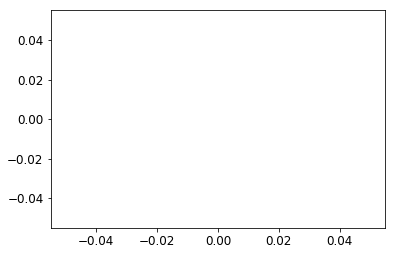

In [140]:
logistic_regression_stochastic_gradient_descent_demo(y_tr, X_tr)

In [ ]:
#SGD - grid search?!
#standardise
#newton 
#confusion matrix